## P. Ginsparg (May, 2017; ported to python3 on 25 Aug 2019)

Piecewise linear fit demo (after Kilian W. talk, Apr 2017), fit a function from 1 variable to 1 variable with width N RELU hidden layer

In [1]:
import matplotlib.pyplot as plt
from scipy.stats import linregress
import ipywidgets as widgets
import numpy as np

mycmap = plt.cm.get_cmap('bwr')  #for the nodes in inset
C = plt.rcParams['axes.prop_cycle'].by_key()['color'] #default color cycle, for lines

In [2]:
def onclick(event):  #input the data points
    global line,txt
    ax.plot(event.xdata, event.ydata, 'ok', zorder=1)
    xdata.append(event.xdata)
    ydata.append(event.ydata)
    if len(xdata)>1:
        if line in ax.lines: ax.lines.remove(line)
        if txt: txt.remove()
        sl,intcpt,r = linregress(xdata,ydata)[:3]
        txt = ax.text(2, -1.75, r'$\rho={:.3f}$'.format(r), fontsize=15, color='r')
        line, = ax.plot(xr, sl*xr+intcpt, 'b--')

In [3]:
def nnfit(x):  #output of nn
    hl = a[:,None]*x + b[:,None]  #hl = a*x+b
    hl[hl<0] = 0  #ReLU
    return c.dot(hl)

In [4]:
def nn(sender): #triggered by entry in text box
  global a,b,c,N,line,txt,handles,C,msize,scpoints,scnodes
  if text.value.isdigit():  #new N
    N = int(text.value)
    text.value = ''
    a = np.random.random(N) - .5  #random initialization
    b = -np.linspace(-5,5,N+2)[1:-1]*a #space out the turn-on point
    c = np.random.random(N) -.5   #random initialization
    ax.set_title('ReLU [1 {} 1]'.format(N))
    if line and line.get_linestyle() == '-': 
        line.set_linestyle('--') #make any previous dotted
        line.set_alpha(.5)       #and lighter
        line=None  #reinit for next line

    ax1.cla()  #inset at right
    ax1.axis('off')
    v_off = (1 if N<8 else 0) #smaller N doesn't fill vertical
    ax1.set_ylim(-1-v_off, N+v_off)
    ax1.set_xlim(-2,2)
    msize = .9*min(20, 4*64./N) #tune size of nodes
    ax1.plot([-1,0], [[(N-1.)/2]*N, range(N)], 'k',  #the edges
              [0,1], [range(N), [(N-1.)/2]*N], 'k', zorder=1);
    ax1.plot([-1,1],[(N-1.)/2]*2,'o', color='lightgray', ms=msize, mec='k', mew=.8) #i/o nodes
    eta = .001
    Jtol = .01

  else:   #no new N, so continue iterating previous
    handles=handles[:-1]  #will add that handle back in at bottom
    eta = .0005 #pseudo-adaptive for smaller J
    Jtol = .001 #tolerance for stopping
        
  lastJ = -1
  for _ in range(100000):
    hl = a[:,None]*xdata + b[:,None]  #a*x+b  (N,ndata)
    hl[hl<0] = 0                 # ReLU for hidden layer
    dy = c.dot(hl) - ydata       # (ndata)
    dc = hl.dot(dy)              # (N) backprop
    db = c*(hl>0).dot(dy)        # (N)  "
    da = c*(hl>0).dot(dy*xdata)  # (N)  "
    a -= eta*da
    b -= eta*db
    c -= eta*dc
    if _%500 == 0:  #update lines every 500
      delta = nnfit(xdata) - ydata
      J = delta.dot(delta) #squared loss
      if line in ax.lines: ax.lines.remove(line)
      ba = sorted(np.append(-b/a, [-5.5,5.5]))
      line, = ax.plot(ba, nnfit(ba), '.-', color=C[len(handles)%len(C)],  ##plot the line
                          label='N={}'.format(N), zorder=1)
      if txt: txt.remove()
      txt = ax.text(3,-1.75,'J={:.3f}'.format(J,fontsize=15,color='r'))
    
      x,s,sl = zip(*sorted(zip(-b/a, np.sign(a), a*c), key=lambda x: x[0]))
      ec = ['#0000BB' if si>0 else '#BB0000' for si in s]  #edge color
      msl = max(abs(a*c))  #max face color
      if scpoints: scpoints.remove() #draw the nodes on the line
      scpoints = ax.scatter(x, nnfit(x), s=25, c=-np.array(sl)*.5/msl, cmap=mycmap,
                                ec=ec, zorder=2)
      if scnodes: scnodes.remove() # also update inset at right
      scnodes = ax1.scatter([0]*N, range(N), s=msize**2, c=-np.array(sl)*.5/msl, cmap=mycmap, 
                                    ec=ec, lw=.8, zorder=2)
      fig.canvas.draw()

    if _%10000 == 0:  #check J every 10000
        if abs(J - lastJ) < Jtol: break    
        lastJ = J

  handles.append(line) #update legend and stop
  txt.set_color('b')
  ax.legend(handles=handles, bbox_to_anchor=(.85, .88), bbox_transform=plt.gcf().transFigure)          

<IPython.core.display.Javascript object>


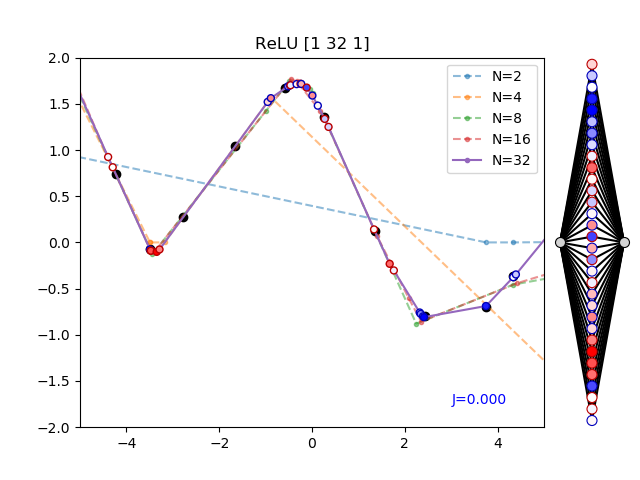

Text(value='', description='N=', layout=Layout(left='200pt', width='50pt'), style=DescriptionStyle(description…

In [5]:
%matplotlib notebook
xdata=[]
ydata=[]
handles=[]
xr = np.linspace(-5,5,3)

fig = plt.figure()
ax = fig.add_subplot(111)  #main fig
ax.set_xlim(-5,5)
ax.set_ylim(-2,2)
plt.subplots_adjust(right=.85)

ax1=plt.axes([0.825, .1, .2, .79]) #inset at right (l,b,w,h)
ax1.axis('off')

txt = None
line = None
scpoints = None
scnodes = None
cid = fig.canvas.mpl_connect('button_press_event', onclick)

text = widgets.Text(description='N=', style = {'description_width': 'initial'},
                    layout=widgets.Layout(width='50pt', left='200pt'))
display(text)
text.on_submit(nn);

In [6]:
fig.canvas.mpl_disconnect(cid)